# Example: Quick fault detection in one line of code
Shows how to use quick fault detection module using example data from the [CARE to Compare dataset](https://doi.org/10.5281/zenodo.14958989)
Structure:
1. Importing
2. Data format preparation
3. Running the analysis

In [2]:
from energy_fault_detector.evaluation import Care2CompareDataset
from energy_fault_detector.quick_fault_detection import quick_fault_detector

# Bring the data into the right format
The quick failure detection function expects tabular data which is provided in csv-format. The data may have a time column which needs to be specified and
there needs to be a separate training and test dataset, which can either be specified through a train_test column like in the CARE to Compare dataset or by providing an additional csv-file.
Also, it is useful to exclude or transform features which represent counters or angles since this will improve the performance of the underlying autoencoder approach.

In [3]:
# Specify the path to the data
data_path = '../../CARE_To_Compare_v5'
c2c = Care2CompareDataset(path=data_path)

import pandas as pd
from typing import List, Tuple

def select_column_names(feature_descriptions: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Update config based on provided feature descriptions.
    Updates the feature to exclude and angle lists of the data preprocessor steps.

    Args:
        feature_descriptions (pd.DataFrame): Feature description dataframe with columns
            sensor_name, statistics_type, is_counter, is_angle
    """

    def get_columns(feature_description_selection: pd.DataFrame) -> List[str]:
        col_suffix = {
            'average': 'avg',
            'minimum': 'min',
            'maximum': 'max',
            'std_dev': 'std'
        }
        columns = []
        for _, row in feature_description_selection.iterrows():
            if row.statistics_type == 'average':
                # in this case the column can be either sensor_i or sensor_i_avg, so we add both
                columns.append(row.sensor_name)
            for stat in row.statistics_type.split(','):
                columns.append(f'{row.sensor_name}_{col_suffix[stat]}')
        return columns

    def get_min_max_std_columns(feature_description_selection: pd.DataFrame) -> List[str]:
        col_suffix = {
            'minimum': 'min',
            'maximum': 'max',
            'std_dev': 'std'
        }
        columns = []
        for _, row in feature_description_selection.iterrows():
            for stat in row.statistics_type.split(','):
                if stat != 'average':
                    columns.append(f'{row.sensor_name}_{col_suffix[stat]}')
        return columns

    angles = feature_descriptions.loc[feature_descriptions['is_angle']]
    to_exclude = feature_descriptions.loc[feature_descriptions['is_counter']]
    angle_columns = get_columns(angles)
    exclude_columns = get_columns(to_exclude)
    exclude_columns += get_min_max_std_columns(feature_descriptions)
    exclude_columns.append('id')
    return angle_columns, exclude_columns

angles, features_to_exclude = select_column_names(feature_descriptions=c2c.feature_descriptions['C'])

# Use the quick failure detection function

Example with automatic optimization

In [4]:
csv_path = '../../CARE_To_Compare_v5/Wind Farm C/datasets/44.csv'

2025-07-03 13:02:04,122 - fault_detection - INFO - Starting Automated Energy Fault Detection an Identification.
2025-07-03 13:02:04,124 - fault_detection - INFO - Loading Data...
2025-07-03 13:02:08,186 - fault_detection - INFO - Selecting suitable config...
2025-07-03 13:02:10,675 - fault_detection - INFO - Initialize models..
2025-07-03 13:02:10,777 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:02:13,851 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:02:16,143 - fault_detection - INFO - Training a Normal behavior model.
2025-07-03 13:02:16,143 - fault_detection - INFO - Initialize models..
2025-07-03 13:02:16,402 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:02:18,478 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:02:20,546 - fault_detection - INFO - Train autoencoder.
Epoch 1/10
306/306 [==============================] - 3s 4ms/step - loss: 0.0475 - mean_absolute_error: 0.1424 - val_loss: 0.0257 - va

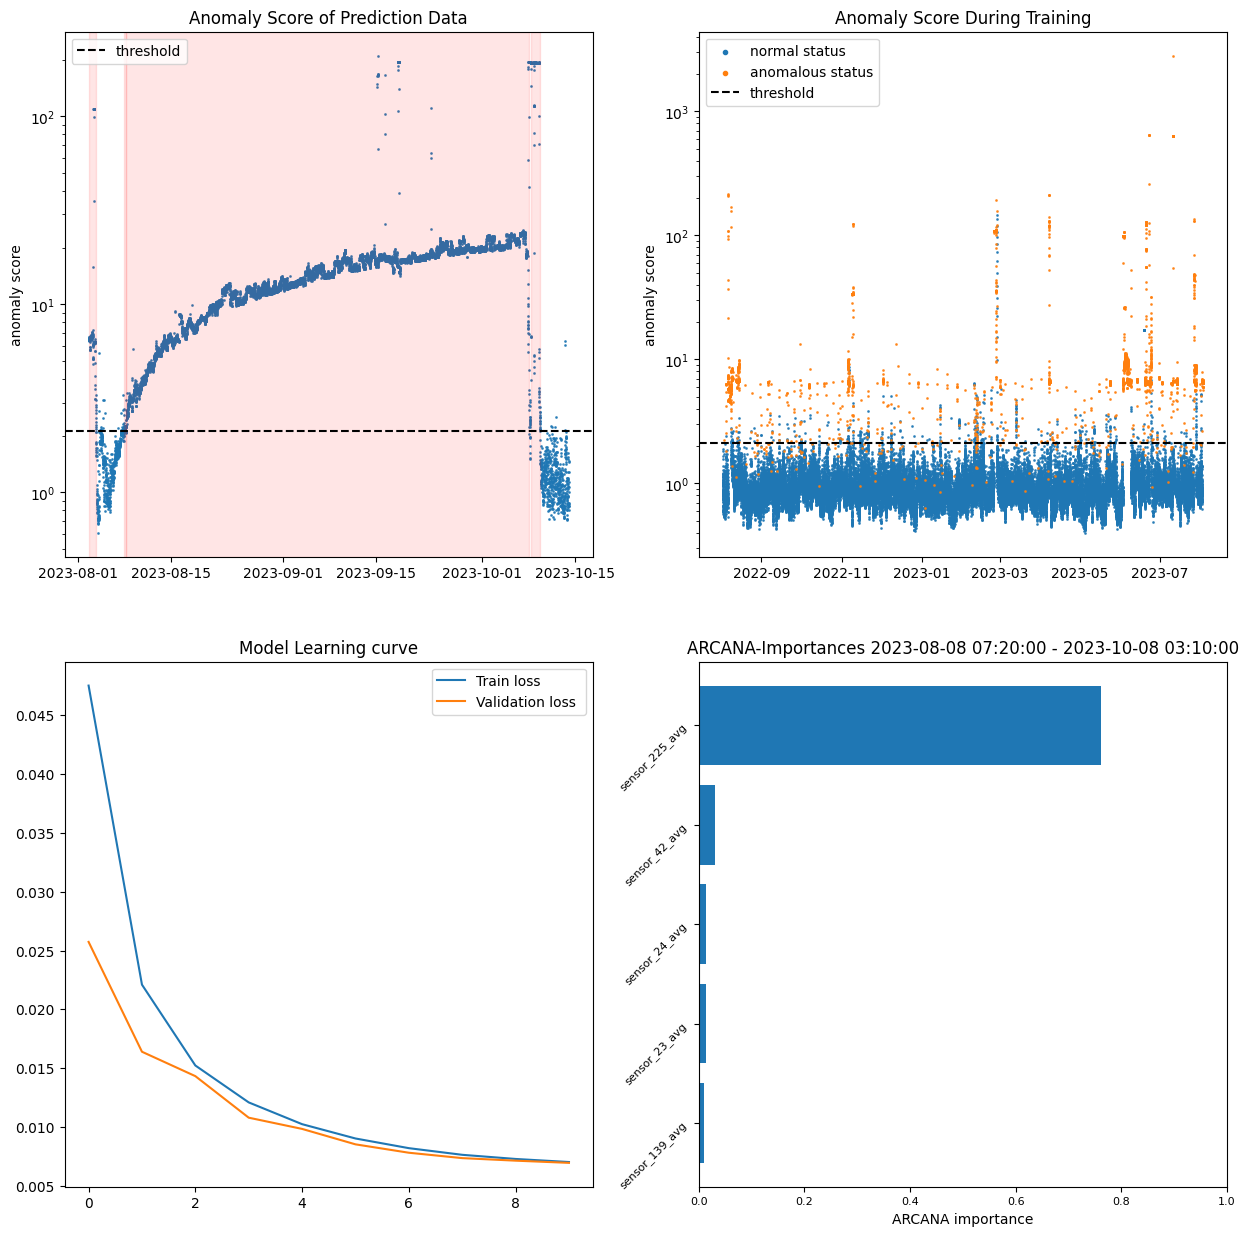

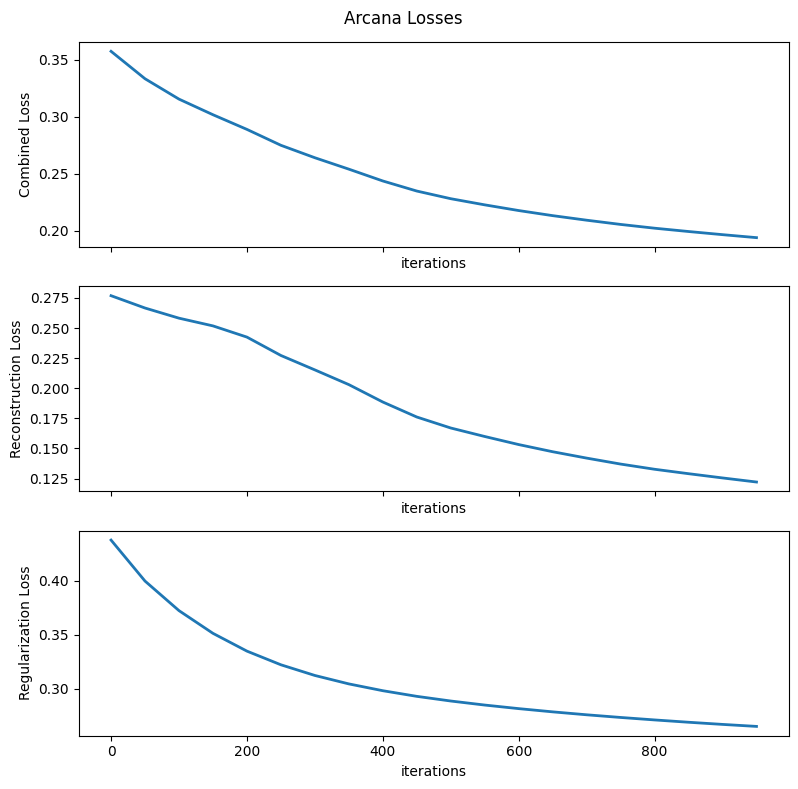

In [5]:
_ = quick_fault_detector(csv_data_path=csv_path, train_test_column_name='train_test',
          train_test_mapping={'train': True, 'prediction': False},
          time_column_name='time_stamp',
          status_data_column_name='status_type_id',
          status_mapping={0: True, 1: False, 2: True, 3: False, 4: False, 5: False},
          features_to_exclude=features_to_exclude, angle_features=angles,
          automatic_optimization=False, enable_debug_plots=True,
          status_label_confidence_percentage=0.99)

# Usage of the quick failure detection method with minimal input

2025-07-03 13:04:25,306 - fault_detection - INFO - Starting Automated Energy Fault Detection an Identification.
2025-07-03 13:04:25,310 - fault_detection - INFO - Loading Data...
2025-07-03 13:04:29,188 - fault_detection - WARNING - No status information was provided for the training data. The normal behavior model will be trained on the entire provided training data which may lead to distorted normal behavior models if the training data does not contain exclusively normal behavior.
2025-07-03 13:04:29,331 - fault_detection - INFO - Selecting suitable config...
2025-07-03 13:04:30,677 - fault_detection - INFO - Initialize models..
2025-07-03 13:04:30,741 - fault_detection - INFO - Clip data before scaling.
2025-07-03 13:04:33,058 - fault_detection - INFO - Fit preprocessor pipeline.
2025-07-03 13:04:34,076 - fault_detection - INFO - Training a Normal behavior model.
2025-07-03 13:04:34,076 - fault_detection - INFO - Initialize models..
2025-07-03 13:04:34,178 - fault_detection - INFO -

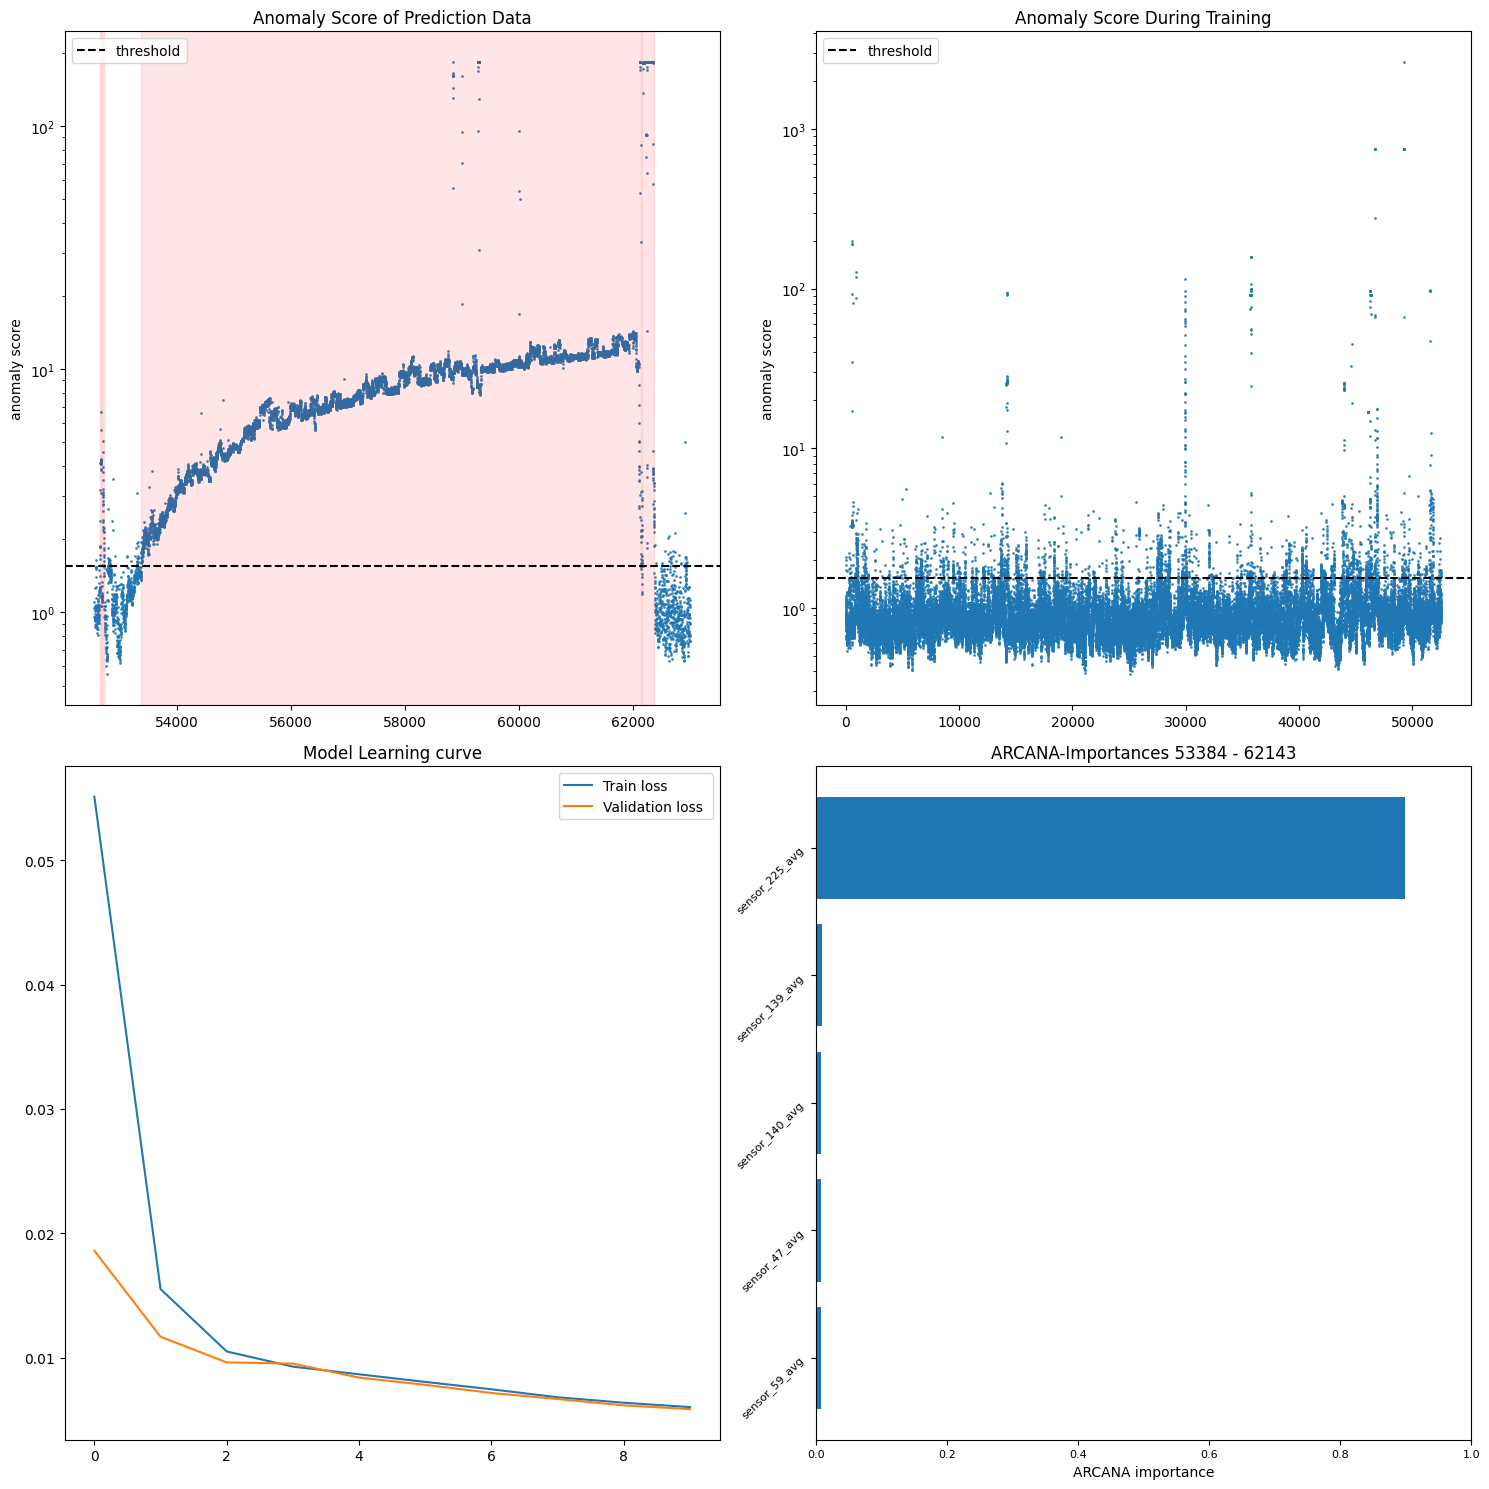

(FaultDetectionResult(predicted_anomalies=       anomaly
 52560    False
 52561    False
 52562    False
 52563    False
 52564    False
 ...        ...
 62998    False
 62999    False
 63000    False
 63001    False
 63002    False
 
 [10443 rows x 1 columns], reconstruction=       status_type_id  sensor_0_avg  sensor_1_avg  power_2_avg  sensor_3_avg  \
 52560        3.116798     -0.961842      0.000765    -0.013544     10.530199   
 52561        3.344513     -1.374837     -0.009944     0.004843     22.773188   
 52562        3.178532     -1.016458     -0.000065    -0.010886     13.181761   
 52563        3.320321     -0.745727     -0.007369     0.001849     16.049397   
 52564        3.237916     -1.025910     -0.002530    -0.006512     14.229364   
 ...               ...           ...           ...          ...           ...   
 62998        0.015776     34.952568     -0.006022     0.419250     83.892349   
 62999        0.043917     29.820425     -0.004344     0.367653     85.93041

In [6]:
quick_fault_detector(csv_data_path=csv_path, train_test_column_name='train_test',
                  train_test_mapping={'train': True, 'prediction': False},
                  automatic_optimization=False,
                  features_to_exclude=features_to_exclude)